## 1. 차량 이미지 파일 읽기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cv2 import cv2
import pytesseract

pytesseract은 Python에서 Tesseract OCR 엔진에 액세스하기 위한 인터페이스입니다. Tesseract OCR은 Google에서 개발한 오픈 소스 OCR(광학 문자 인식) 엔진으로, 이미지에서 텍스트를 추출하는 데 사용됩니다.

이미지 크기 : (720, 960, 3)


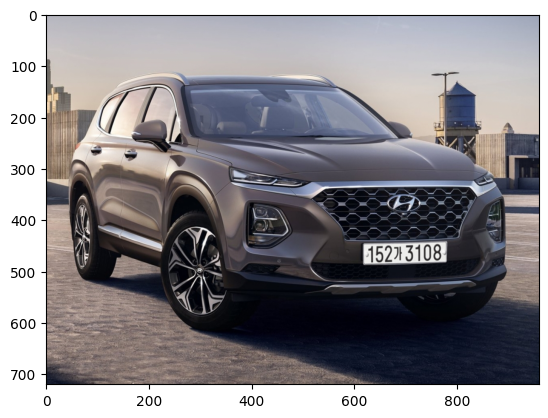

In [2]:
image_path = './data/car_license_plate.jpeg'
image = cv2.imread(image_path)
# 색상의 문제 발생 BGR -> RGB 컨버터 필요
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, c = image.shape
print(f"이미지 크기 : ({h}, {w}, {c})")
plt.imshow(image)
plt.show()

## 2. 차량 이미지 GrayScale 변환

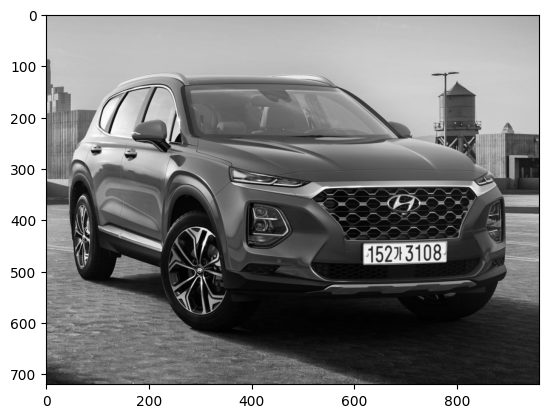

In [3]:
image_path = './data/car_license_plate.jpeg'
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_image, 'gray')
plt.show()

## 3. 차량 이미지 - Maximize Contrast

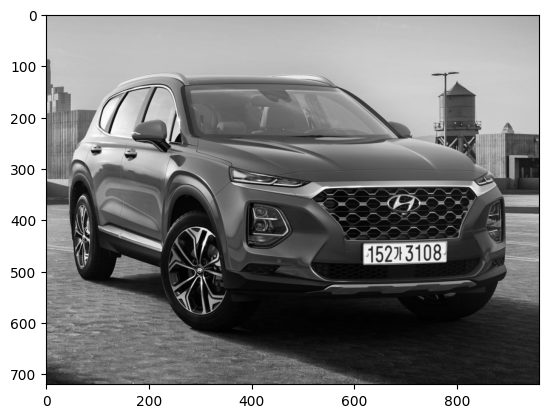

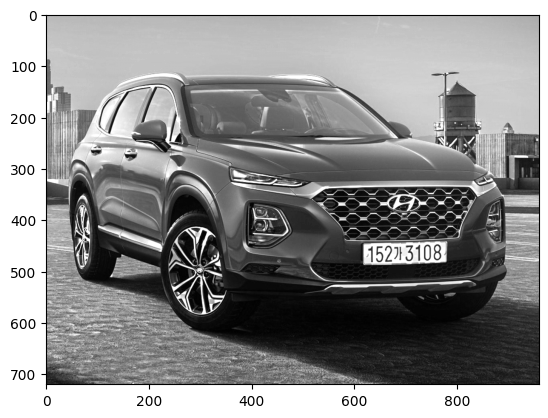

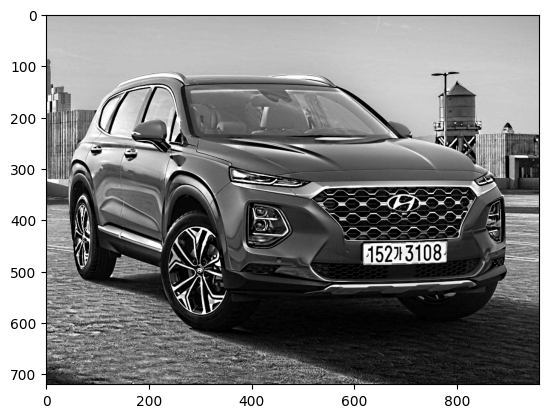

In [4]:
image_path = './data/car_license_plate.jpeg'
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_image, 'gray')
plt.show()

# 모폴로지 연산 
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))

# TOPHAT -> 밝기 값이 크게 변화하는 영역을 강조
imgTophat = cv2.morphologyEx(gray_image, cv2.MORPH_TOPHAT, structuringElement)

# BLACKHAT -> 어두운 부분을 강조
imgBlackHat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, structuringElement)

# 합치기 
imgGrayscalePlusTophat = cv2.add(gray_image, imgTophat)
plt.imshow(imgGrayscalePlusTophat, 'gray')
plt.show()

# 뺄셈 연산
imgGrayscaleMinusTophat = cv2.subtract(imgGrayscalePlusTophat, imgBlackHat)
plt.imshow(imgGrayscaleMinusTophat, 'gray')
plt.show()

## 4. 차량 이미지 - 이진화

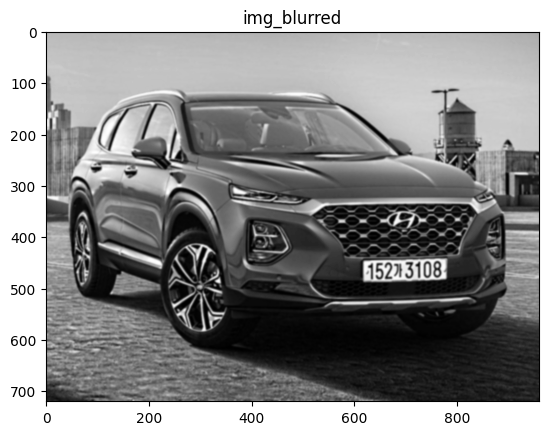

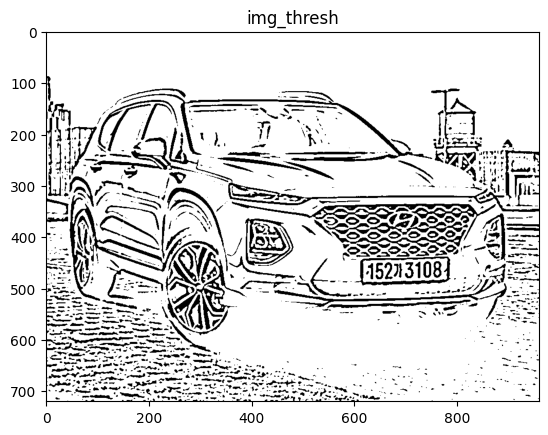

In [5]:
img_blurred = cv2.GaussianBlur(imgGrayscaleMinusTophat, ksize=(7,7), sigmaX=0)

plt.imshow(img_blurred, 'gray')
plt.title('img_blurred')
plt.show()

img_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue = 255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY,
    blockSize=19,
    C=9
)

plt.imshow(img_thresh, 'gray')
plt.title('img_thresh')
plt.show()

## 5. 차량 이미지 - Find Contours (이미지에서 객체의 외곽선 검출)

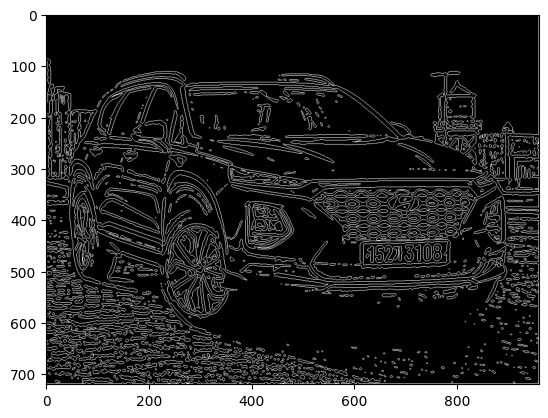

In [6]:
contours, hierarchy = cv2.findContours(
    img_thresh,
    mode = cv2.RETR_LIST,
    method = cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((h, w, c), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.imshow(temp_result, 'gray')
plt.show()

## 6. 차량 이미지 전처리 (바운딩 박스 표시)

mode: 윤곽선을 검색하는 방법을 지정합니다. 일반적으로 cv2.RETR_LIST, cv2.RETR_EXTERNAL, cv2.RETR_TREE 등의 값을 사용합니다.
method: 윤곽선 근사화 방법을 지정합니다. 보통 cv2.CHAIN_APPROX_SIMPLE, cv2.CHAIN_APPROX_TC89_L1, 
cv2.CHAIN_APPROX_TC89_KCOS 등의 값을 사용합니다

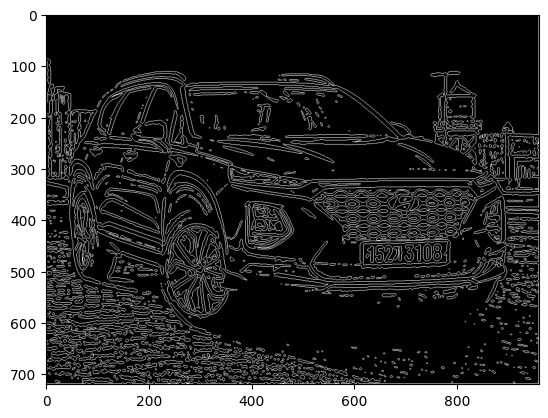

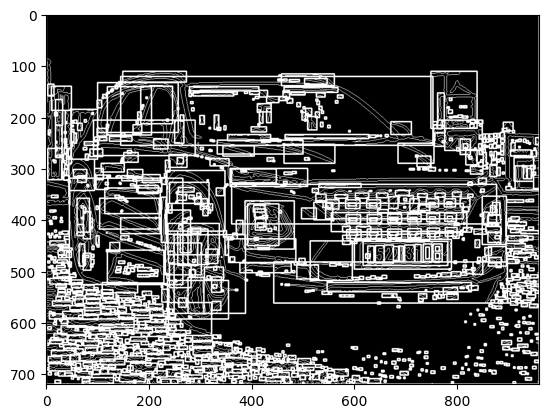

In [7]:
# temp_result = np.zeros((h, w, c), dtype=np.uint8)

plt.imshow(temp_result, 'gray')
plt.show()

contours_dict = []


for contour in contours : 
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x,y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour' : contour,
        'x' : x,
        'y' : y,
        'w' : w,
        'h' : h,
        'cx' : x + (w / 2),
        'cy' : y + (h / 2)
    })
plt.imshow(temp_result, 'gray')
plt.show()

## 7. 차량 이미지 Select Candidate by Char size

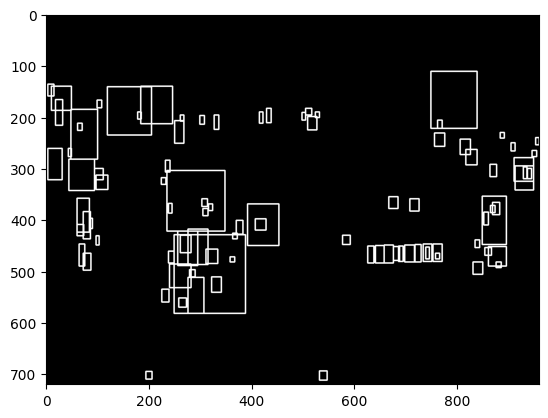

In [8]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0 

possible_contours = []

count = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MAX_RATIO > ratio > MIN_RATIO :
        d['idx'] = count
        count += 1
        possible_contours.append(d)
        
temp_result_ = np.zeros((h, w, c), dtype=np.uint8)

for d in possible_contours :
    x1, w1, y1, h1 = d['x'], d['w'], d['y'], d['h']
    cv2.rectangle(temp_result_, (x1, y1), (x1+w1, y1+h1), color=(255,255,255), thickness=2)
plt.imshow(temp_result_, 'gray')
plt.show()

## 8. 차량 이미지 - Select Candidates by Arrangement of Contours 변환

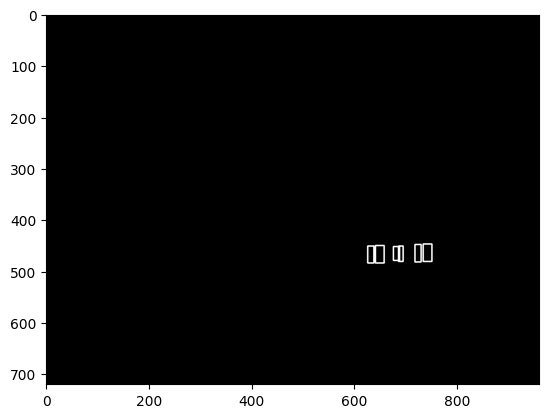

In [9]:
MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 4

def find_chars(contour_list) : 
    matched_result_idx = []
    for d1 in contour_list :
        matched_contour_idx = []
        for d2 in contour_list :
            if d1['idx'] == d2['idx'] :
                continue
                
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            
            diagonal_length1 = np.sqrt(d1['w']**2 + d1['h']**2)
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            
            if dx == 0 :
                angle_diff = 90
            else :
                angle_diff = np.degrees(np.arctan(dy / dx))
              
            # 정규화
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF \
            and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF \
            and height_diff < MAX_HEIGHT_DIFF :
                matched_contour_idx.append(d2['idx'])
        matched_contour_idx.append(d1['idx'])
        
        if len(matched_contour_idx) < MIN_N_MATCHED :
            continue
        
        matched_result_idx.append(matched_contour_idx)
        
        unmatched_contour_idx = []
        for d4 in contour_list : 
            if d4['idx'] not in matched_contour_idx :
                unmatched_contour_idx.append(d4['idx'])
        
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list : 
            matched_result_idx.append(idx)
        break
    return matched_result_idx
        
result_idx = find_chars(possible_contours)
matched_result = []
for idx_list in result_idx : 
    matched_result.append(np.take(possible_contours, idx_list))
    
temp_result = np.zeros((h, w, c), dtype=np.uint8)

for r in matched_result : 
    for d in r :
        x1_temp = d['x']
        y1_temp = d['y']
        w1_temp = d['w']
        h1_temp = d['h']
        cv2.rectangle(temp_result, (x1_temp,y1_temp), (x1_temp+w1_temp, y1_temp+h1_temp), (255,255,255), thickness=2)
        
plt.imshow(temp_result, 'gray')
plt.show()

## 9. 차량 번호판 이미지 회전시키는 작업 01

In [10]:
PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result) : 
    sorted_chars = sorted(matched_chars, key=lambda x : x['cx'])
    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) /2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) /2
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w']- sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    sum_height = 0
    for d in sorted_chars :
        sum_height += d['h']
    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )

sorted_chars 리스트에서 가장 오른쪽 요소와 가장 왼쪽 요소의 'x' 값과 너비('w')를 이용하여 번호판의 폭을 계산하는 부분입니다.

리스트에 있는 각 요소의 높이('h') 값을 모두 더한 후, 평균 높이를 계산하여 번호판의 높이를 결정하는 부분입니다.

## 차량 번호판 이미지 회전시키는 작업 02

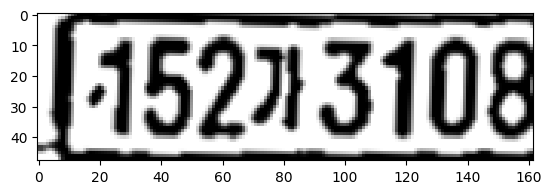

In [11]:
angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)

img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(w,h))

img_cropped = cv2.getRectSubPix(
    img_rotated,
    patchSize=(int(plate_width), int(plate_height)),
    center = (int(plate_cx), int(plate_cy))
)

plate_imgs.append(img_cropped)

plate_infos.append({
    'x' : int(plate_cx - plate_width / 2),
    'y' : int(plate_cy - plate_height / 2),
    'w' : int(plate_width),
    'h' : int(plate_height)
})

plt.imshow(img_cropped, 'gray')
plt.show()

## 차량 번호판 : Another Thresholding to Find Chars

In [12]:
longest_idx, longest_text = -1, 0
plate_chars = []
for i, plate_img in enumerate(plate_imgs) :
    plate_img = cv2.resize(plate_img, dsize=(0,0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    contours, hierarchy = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0
    
    for contour in contours :
        contour_x, contour_y, contour_w, contour_h = cv2.boundingRect(contour)
        print(contour_x, contour_y, contour_w, contour_h)
        
        area_temp = contour_w * contour_h
        ratio = contour_w / contour_h
        
        if area_temp > MIN_AREA \
        and contour_w > MIN_WIDTH and contour_h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO :
            
            if contour_x < plate_min_x :
                plate_min_x = contour_x
            if contour_y < plate_min_y :
                plate_min_y = contour_y
            if contour_x + contour_w < plate_max_x :
                plate_max_x = contour_x + contour_w
            if contour_y + contour_h < plate_max_y :
                plate_max_y = contour_y + contour_h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    img_result = cv2.GaussianBlur(img_result, ksize=(3,3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

    plt.imshow(img_result, 'gray')
    plt.show()
text = pytesseract.image_to_string(img_result)
print(text)

0 71 12 6
242 42 13 17
26 37 11 13
244 21 11 14
213 21 11 37
112 16 28 46
179 13 19 53
146 13 30 52
32 13 19 52
204 12 27 54
55 12 27 54
83 11 27 55
16 4 243 70
236 0 2 1
185 0 22 1
135 0 20 1
0 0 17 69


error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'cv::GaussianBlur'


## 차량 번호판 바운딩 박스 표시 결과 이미지

{'x': 606, 'y': 441, 'w': 162, 'h': 48}


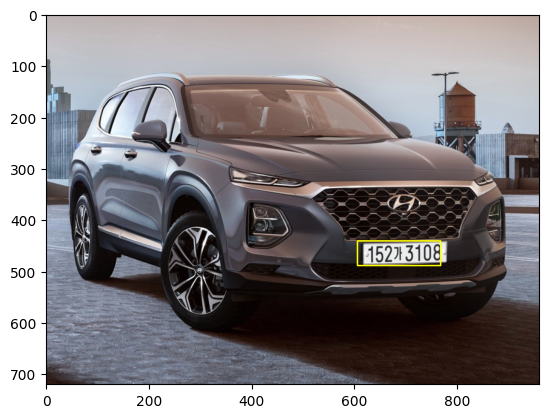

In [13]:
info = plate_infos[longest_idx] 
img_out = image.copy()
print(info)
cv2.rectangle(img_out, (info['x'], info['y']), (info['x']+info['w'], info['y']+info['h']),
             (255,255,0), thickness=2)
plt.imshow(img_out)
plt.show()